# Capstone Project - Predicting Car Crash Severity 

In [186]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print('Matplotlib version: ', mpl.__version__) # >= 2.0.0

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline

import seaborn as sns

from sklearn.utils import resample
from sklearn import preprocessing

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix,f1_score
import itertools
from sklearn.metrics import jaccard_score

from datetime import datetime


%matplotlib inline

Matplotlib version:  3.2.2


In [16]:
# print confusion matrix and graph
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    
# ----------------------------------------------------------------------------
# Percentage Barh Plots
def mybarh_plot(orgdata,feature, **kwarg):
    org_num = orgdata[feature].value_counts().sort_values(ascending=True)
#    org_num = orgdata[feature].value_counts()
    ratiodata = pd.DataFrame(orgdata[feature].value_counts().sort_values(ascending=True).apply(lambda x : x/orgdata[feature].value_counts().sum())*100)
    
    ax = ratiodata[feature].sort_values().plot(kind='barh', **kwarg)
    i = 0
    ax.patches
    for p in ax.patches:
        width = p.get_width()
#        print(width, org_num[org_num.index[i]])
        plt.text(5 + width, p.get_y() + 0.55 * p.get_height(),
                 '{:1.2f}% ,{:d}'.format(width,org_num[org_num.index[i]]),
                 ha='center', va='center')
        plt.title(feature)
        i = i+1

    ratiodata.rename(columns={feature:'percent'},inplace=True)
    ratiodata[feature] = org_num.values
        
    return ratiodata.sort_values(by='percent',ascending=False)

def perc_data(series, name=None):
    values = series.value_counts()
    expanded_value = values.to_frame(name)
    expanded_value['percent'] = values.apply(lambda _: _ / series.size * 100)
    return expanded_value

## Import CSV data

In [7]:
# import csv data
df_crashData = pd.read_csv('Capstone_project\\dataset\\Data-Collisions.csv')

C:\Users\Tian_Erika\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3071: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
print('The dataset has {:3,d} samples and {} features'.format(*df_crashData.shape))

The dataset has 194,673 samples and 38 features


In [9]:
df_crashData.describe(include='all')

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
count,194673.000000,189339.000000,189339.000000,194673.000000,194673.000000,194673.000000,194673,194673,192747,65070.000000,...,189661,189503,4667,1.149360e+05,9333,194655,189769,194673.000000,1.946730e+05,194673
unique,NaN,NaN,NaN,NaN,NaN,NaN,194670,2,3,NaN,...,9,9,1,NaN,1,115,62,NaN,NaN,2
top,NaN,NaN,NaN,NaN,NaN,NaN,1776526,Matched,Block,NaN,...,Dry,Daylight,Y,NaN,Y,32,One parked--one moving,NaN,NaN,N
freq,NaN,NaN,NaN,NaN,NaN,NaN,2,189786,126926,NaN,...,124510,116137,4667,NaN,9333,27612,44421,NaN,NaN,187457
mean,1.298901,-122.330518,47.619543,108479.364930,141091.456350,141298.811381,NaN,NaN,NaN,37558.450576,...,NaN,NaN,NaN,7.972521e+06,NaN,NaN,NaN,269.401114,9.782452e+03,NaN
std,0.457778,0.029976,0.056157,62649.722558,86634.402737,86986.542110,NaN,NaN,NaN,51745.990273,...,NaN,NaN,NaN,2.553533e+06,NaN,NaN,NaN,3315.776055,7.226926e+04,NaN
min,1.000000,-122.419091,47.495573,1.000000,1001.000000,1001.000000,NaN,NaN,NaN,23807.000000,...,NaN,NaN,NaN,1.007024e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
25%,1.000000,-122.348673,47.575956,54267.000000,70383.000000,70383.000000,NaN,NaN,NaN,28667.000000,...,NaN,NaN,NaN,6.040015e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
50%,1.000000,-122.330224,47.615369,106912.000000,123363.000000,123363.000000,NaN,NaN,NaN,29973.000000,...,NaN,NaN,NaN,8.023022e+06,NaN,NaN,NaN,0.000000,0.000000e+00,NaN
75%,2.000000,-122.311937,47.663664,162272.000000,203319.000000,203459.000000,NaN,NaN,NaN,33973.000000,...,NaN,NaN,NaN,1.015501e+07,NaN,NaN,NaN,0.000000,0.000000e+00,NaN


In [10]:
# Drop unused columns
drop = ['SEVERITYCODE.1','X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO', 'STATUS', 'LOCATION', 'EXCEPTRSNCODE', 'EXCEPTRSNDESC', 'SEVERITYDESC', 'SDOT_COLDESC',
        'SDOTCOLNUM', 'ST_COLDESC', 'SEGLANEKEY', 'CROSSWALKKEY']
df_crashData.drop(drop, axis=1, inplace=True)

In [11]:
# Fill missing data with '###'
df_crashData.fillna('###', inplace=True)

In [12]:
df_crashData.columns

Index(['SEVERITYCODE', 'ADDRTYPE', 'INTKEY', 'COLLISIONTYPE', 'PERSONCOUNT',
       'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE', 'INCDTTM',
       'JUNCTIONTYPE', 'SDOT_COLCODE', 'INATTENTIONIND', 'UNDERINFL',
       'WEATHER', 'ROADCOND', 'LIGHTCOND', 'PEDROWNOTGRNT', 'SPEEDING',
       'ST_COLCODE', 'HITPARKEDCAR'],
      dtype='object')

## Data Cleaning

### Severity
it's imbalance data, need upsample/downsample before feeding to model.

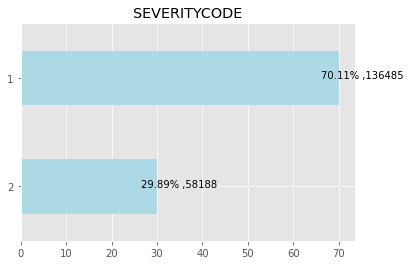

In [17]:
tmpdata = mybarh_plot(df_crashData,'SEVERITYCODE',color='lightblue')

### COLLISIONTYPE


,SEVERITYCODE,percent
1,3863,78.772431
2,1041,21.227569


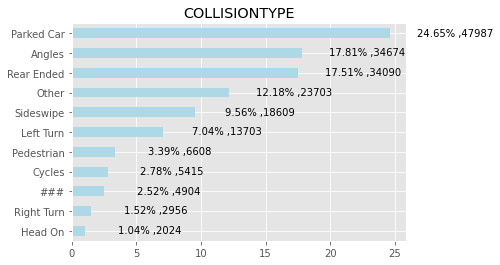

In [18]:
mybarh_plot(df_crashData,'COLLISIONTYPE',color='lightblue')
tmpdata = df_crashData[df_crashData['COLLISIONTYPE'] == '###']
perc_data(tmpdata['SEVERITYCODE'])

In [19]:
# replaced balnk to Unknown as checked, it has similar ratio(Severity) to Unknow.
df_crashData['COLLISIONTYPE'].replace('###','Unknown', inplace=True)

### JUNCTIONTYPE

,SEVERITYCODE,percent
1,5929,93.679886
2,400,6.320114


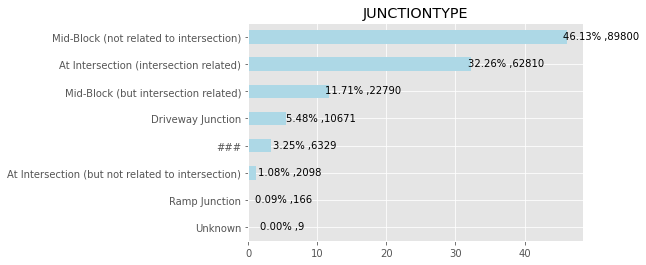

In [20]:
tmpdata = mybarh_plot(df_crashData,'JUNCTIONTYPE',color='lightblue')
tmpdata = df_crashData[df_crashData['JUNCTIONTYPE'] == '###']
perc_data(tmpdata['SEVERITYCODE'])

In [21]:
# replaced balnk with Unknown
df_crashData['JUNCTIONTYPE'].replace('###','Unknown', inplace=True)

### Vehicle Count vs. Severity

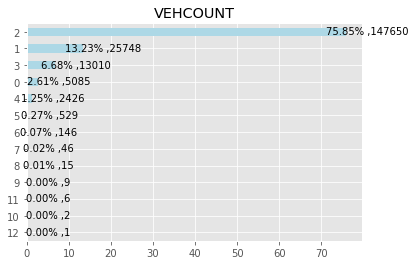

In [22]:
tmpdata = mybarh_plot(df_crashData,'VEHCOUNT',color='lightblue')

In [35]:
vehCount2 = df_crashData[df_crashData['VEHCOUNT'] >= 9]
perc_data(vehCount2['SEVERITYCODE'])

,SEVERITYCODE,percent
2,11,61.111111
1,7,38.888889


In [36]:
vehCount2.index

Int64Index([ 16074,  18265,  53735,  56677,  63002,  81376,  84013,  85498,
             97174, 108338, 109557, 120882, 121833, 151678, 152289, 168471,
            172350, 193583],
           dtype='int64')

In [37]:
# drop VEHCOUNT = 9,10,11,12
df_crashData.drop(vehCount2.index, inplace=True)

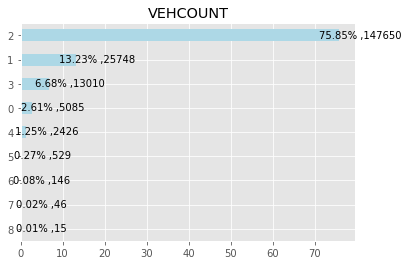

In [38]:
tmpdata = mybarh_plot(df_crashData,'VEHCOUNT',color='lightblue')

### SDOT_COLCODE 
MOTOR VEHICLE STRUCK MOTOR VEHICLE, FRONT END AT ANGLE

,percent,SDOT_COLCODE
11,43.771801,85204
14,27.891911,54293
16,5.099278,9926
0,5.027356,9786
28,4.549074,8855
24,3.348488,6518
13,3.006345,5852
26,2.434564,4739
18,1.594616,3104
15,0.823508,1603


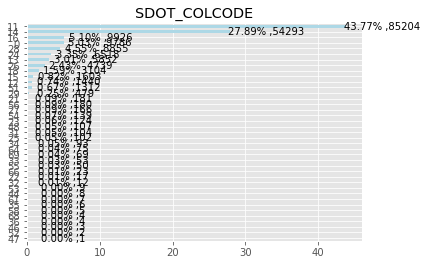

In [41]:
mybarh_plot(df_crashData,'SDOT_COLCODE',color='lightblue')

In [67]:
sdot = df_crashData[df_crashData['SDOT_COLCODE'] == 47]
perc_data(sdot['SEVERITYCODE'])

,SEVERITYCODE,percent
1,1,100.0


In [68]:
# drop SDOT = 53,44,61,35,58,68,36,46,52,47
df_crashData.drop(sdot.index, inplace=True)

,percent,SDOT_COLCODE
11,43.782823,85204
14,27.898934,54293
16,5.100562,9926
0,5.028622,9786
28,4.550219,8855
24,3.349331,6518
13,3.007102,5852
26,2.435177,4739
18,1.595018,3104
15,0.823716,1603


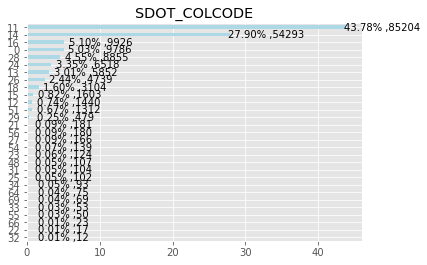

In [69]:
mybarh_plot(df_crashData,'SDOT_COLCODE',color='lightblue')

### INATTENTIONIND
A Whether or not collision was due to inattention. 


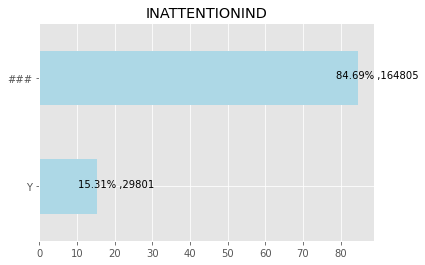

In [70]:
tmpdata = mybarh_plot(df_crashData,'INATTENTIONIND',color='lightblue')

In [71]:
# replaced balnk with 'N'
df_crashData['INATTENTIONIND'].replace('###','N', inplace=True)

In [72]:
tmpdata = df_crashData[df_crashData['INATTENTIONIND'] == 'N']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,117054,71.025758
2,47751,28.974242


### UNDERINFL
Whether or not a driver involved was under the influence of drugs or alcohol

,SEVERITYCODE,percent
1,3855,78.931204
2,1029,21.068796


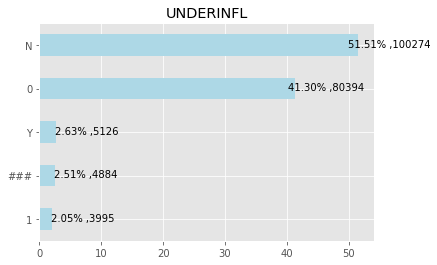

In [536]:
mybarh_plot(df_crashData,'UNDERINFL',color='lightblue')
tmpdata = df_crashData[df_crashData['UNDERINFL'] == '###']
perc_data(tmpdata['SEVERITYCODE'])

In [73]:
# replaced balnk with 'Unknown', built the new class
df_crashData['UNDERINFL'].replace('###','Unknown', inplace=True)

,percent,UNDERINFL
N,51.513314,100248
0,41.293691,80360
Y,2.631985,5122
Unknown,2.509686,4884
1,2.051324,3992


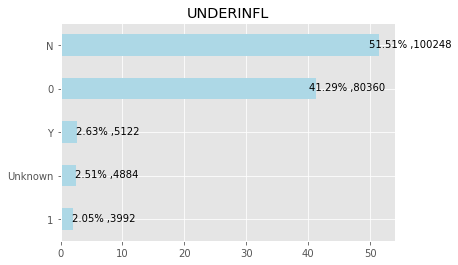

In [74]:
mybarh_plot(df_crashData,'UNDERINFL',color='lightblue')

### WEATHER
replaced balnk to Unknown as checked it has similar ratio to Unknow.

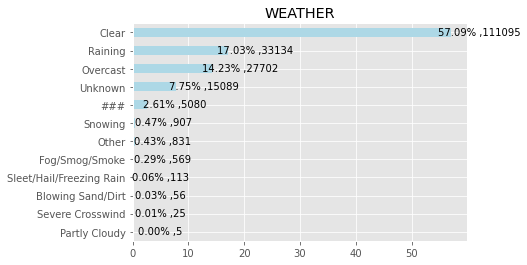

In [75]:
tmpdata = mybarh_plot(df_crashData,'WEATHER',color='lightblue')

In [76]:
tmpdata = df_crashData[df_crashData['WEATHER'] == 'Clear']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,75282,67.763626
2,35813,32.236374


In [77]:
# replaced balnk with Unknown as checked it has similar ratio(Severity) to Unknow.
df_crashData['WEATHER'].replace('###','Unknown', inplace=True)

,percent,WEATHER
Clear,57.087140,111095
Raining,17.026197,33134
Overcast,14.234916,27702
Unknown,10.364018,20169
Snowing,0.466070,907
Other,0.427017,831
Fog/Smog/Smoke,0.292386,569
Sleet/Hail/Freezing Rain,0.058066,113
Blowing Sand/Dirt,0.028776,56
Severe Crosswind,0.012846,25


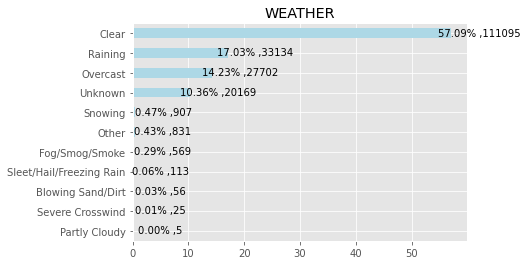

In [78]:
mybarh_plot(df_crashData,'WEATHER',color='lightblue')

### ROADCOND

,SEVERITYCODE,percent
1,89,67.424242
2,43,32.575758


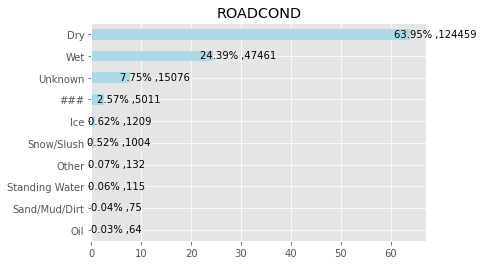

In [79]:
tmpdata = mybarh_plot(df_crashData,'ROADCOND',color='lightblue')
tmpdata = df_crashData[df_crashData['ROADCOND'] == 'Other']
perc_data(tmpdata['SEVERITYCODE'])

In [80]:
tmpdata = df_crashData[df_crashData['ROADCOND'] == '###']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,3952,78.866494
2,1059,21.133506


In [81]:
# replaced balnk with Unknown 
df_crashData['ROADCOND'].replace('###','Unknown', inplace=True)

,percent,ROADCOND
Dry,63.954349,124459
Wet,24.388251,47461
Unknown,10.321881,20087
Ice,0.621255,1209
Snow/Slush,0.515914,1004
Other,0.067829,132
Standing Water,0.059094,115
Sand/Mud/Dirt,0.038539,75
Oil,0.032887,64


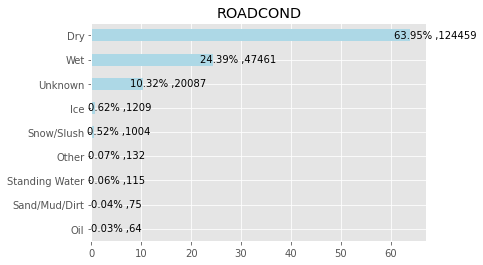

In [82]:
mybarh_plot(df_crashData,'ROADCOND',color='lightblue')

### LIGHTCOND

,SEVERITYCODE,percent
1,183,77.87234
2,52,22.12766


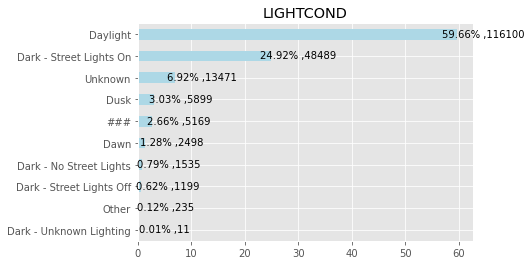

In [83]:
tmpdata = mybarh_plot(df_crashData,'LIGHTCOND',color='lightblue')
tmpdata = df_crashData[df_crashData['LIGHTCOND'] == 'Other']
perc_data(tmpdata['SEVERITYCODE'])

In [84]:
tmpdata = df_crashData[df_crashData['LIGHTCOND'] == '###']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,4080,78.932095
2,1089,21.067905


In [85]:
# replaced balnk with Unknown as checked it has almost same ratio(Severity) to Unknow.
df_crashData['LIGHTCOND'].replace('###','Other', inplace=True)

,percent,LIGHTCOND
Daylight,59.659003,116100
Dark - Street Lights On,24.916498,48489
Unknown,6.922192,13471
Dusk,3.031253,5899
Other,2.776893,5404
Dawn,1.283619,2498
Dark - No Street Lights,0.788773,1535
Dark - Street Lights Off,0.616117,1199
Dark - Unknown Lighting,0.005652,11


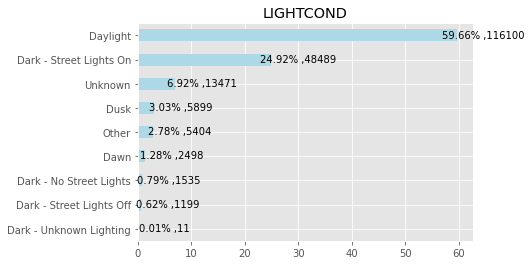

In [86]:
mybarh_plot(df_crashData,'LIGHTCOND',color='lightblue')

### PEDROWNOTGRNT
Whether or not the pedestrian right of way was not grante

,SEVERITYCODE,percent
2,4205,90.139335
1,460,9.860665


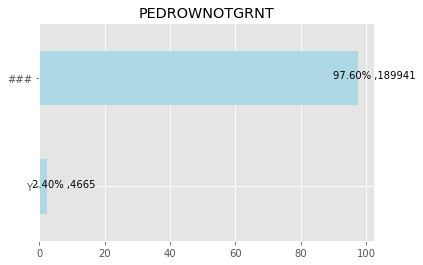

In [87]:
mybarh_plot(df_crashData,'PEDROWNOTGRNT',color='lightblue')
tmpdata = df_crashData[df_crashData['PEDROWNOTGRNT'] == 'Y']
perc_data(tmpdata['SEVERITYCODE'])

In [88]:
# replaced balnk with N 
df_crashData['PEDROWNOTGRNT'].replace('###','N', inplace=True)

,percent,PEDROWNOTGRNT
N,97.602849,189941
Y,2.397151,4665


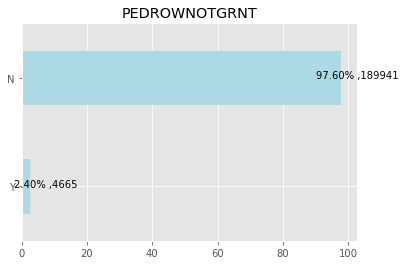

In [89]:
mybarh_plot(df_crashData,'PEDROWNOTGRNT',color='lightblue')

### SPEEDING
Speeding = Yes doesn't lead more 'Injury Collision' so I will remove this feature.

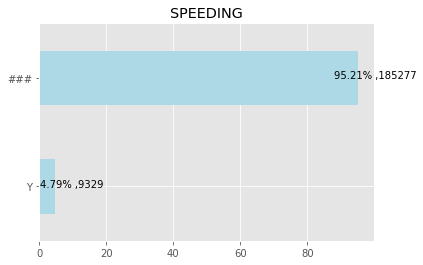

In [90]:
tmpdata = mybarh_plot(df_crashData,'SPEEDING',color='lightblue')

In [91]:
tmpdata = df_crashData[df_crashData['SPEEDING'] == '###']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,130661,70.521975
2,54616,29.478025


In [92]:
# replaced balnk with N 
df_crashData['SPEEDING'].replace('###','N', inplace=True)

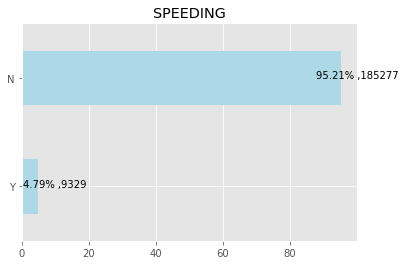

In [93]:
tmpdata = mybarh_plot(df_crashData,'SPEEDING',color='lightblue')

### ST_COLCODE
A code provided by the state that describes the collision. For more information about these codes, please see the State Collision Code Dictionary. 
Example:
Entering at angle
From same direction - both going straight - both moving - sideswipe
One parked--one moving
From same direction - all others
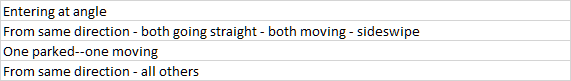

,percent,ST_COLCODE
32,14.184044,27603
10,12.037656,23426
14,8.674964,16882
32,8.632827,16800
10,5.779370,11247
...,...,...
87,0.000514,1
87,0.000514,1
54,0.000514,1
85,0.000514,1


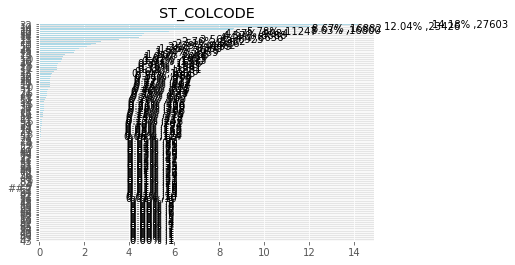

In [94]:
tmpdata = mybarh_plot(df_crashData,'ST_COLCODE',color='lightblue')
tmpdata

In [148]:
tmpdata = df_crashData[df_crashData['ST_COLCODE'] == '54']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent


In [149]:
tmpdata.index

Int64Index([], dtype='int64')

In [129]:
# drop ST_COLCODE = 87, 54, 85,43,42,65,67
df_crashData.drop(tmpdata.index, inplace=True)

### HITPARKEDCAR
Whether or not the collision involved hitting a parked car

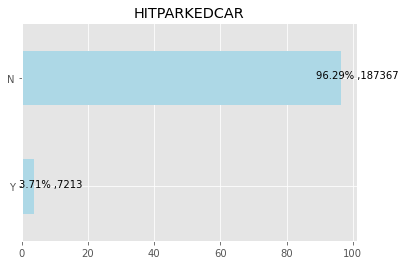

In [151]:
tmpdata = mybarh_plot(df_crashData,'HITPARKEDCAR',color='lightblue')

In [152]:
tmpdata = df_crashData[df_crashData['HITPARKEDCAR'] == 'Y']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,6765,93.788992
2,448,6.211008


### Set Type

In [153]:
# Drop date, time, and ADDRTYPE, INTKEY
df_crashData.drop(['INCDATE','INCDTTM','ADDRTYPE',
        'INTKEY'], axis=1, inplace=True)

In [154]:
df_crashData.dtypes

SEVERITYCODE       int64
COLLISIONTYPE     object
PERSONCOUNT        int64
PEDCOUNT           int64
PEDCYLCOUNT        int64
VEHCOUNT           int64
JUNCTIONTYPE      object
SDOT_COLCODE       int64
INATTENTIONIND    object
UNDERINFL         object
WEATHER           object
ROADCOND          object
LIGHTCOND         object
PEDROWNOTGRNT     object
SPEEDING          object
ST_COLCODE        object
HITPARKEDCAR      object
dtype: object

In [155]:
df_crashData['SEVERITYCODE'] = df_crashData['SEVERITYCODE'].astype('category')
df_crashData['COLLISIONTYPE'] = df_crashData['COLLISIONTYPE'].astype('category')
df_crashData['PERSONCOUNT'] = df_crashData['PERSONCOUNT'].astype('int8')
df_crashData['PEDCOUNT'] = df_crashData['PEDCOUNT'].astype('int8')
df_crashData['PEDCYLCOUNT'] = df_crashData['PEDCYLCOUNT'].astype('int8')
df_crashData['VEHCOUNT'] = df_crashData['VEHCOUNT'].astype('int8')
df_crashData['JUNCTIONTYPE'] = df_crashData['JUNCTIONTYPE'].astype('category')
df_crashData['SDOT_COLCODE'] = df_crashData['SDOT_COLCODE'].astype('category')
df_crashData['INATTENTIONIND'] = df_crashData['INATTENTIONIND'].astype('category')
df_crashData['UNDERINFL'] = df_crashData['UNDERINFL'].astype('category')
df_crashData['WEATHER'] = df_crashData['WEATHER'].astype('category')
df_crashData['ROADCOND'] = df_crashData['ROADCOND'].astype('category')
df_crashData['LIGHTCOND'] = df_crashData['LIGHTCOND'].astype('category')
df_crashData['PEDROWNOTGRNT'] = df_crashData['PEDROWNOTGRNT'].astype('category')
df_crashData['SPEEDING'] = df_crashData['SPEEDING'].astype('category')
df_crashData['ST_COLCODE'] = df_crashData['ST_COLCODE'].astype('category')
df_crashData['HITPARKEDCAR'] = df_crashData['HITPARKEDCAR'].astype('category')

In [156]:
df_crashData.dtypes

SEVERITYCODE      category
COLLISIONTYPE     category
PERSONCOUNT           int8
PEDCOUNT              int8
PEDCYLCOUNT           int8
VEHCOUNT              int8
JUNCTIONTYPE      category
SDOT_COLCODE      category
INATTENTIONIND    category
UNDERINFL         category
WEATHER           category
ROADCOND          category
LIGHTCOND         category
PEDROWNOTGRNT     category
SPEEDING          category
ST_COLCODE        category
HITPARKEDCAR      category
dtype: object

### Export Selected feature to csv

In [157]:
# Export Selected feature to csv
df_crashData.to_csv('Capstone_project\\dataset\\Data-Collisions_Cleaned_v3_0921.csv',index=False)


In [158]:
df_crashData

,SEVERITYCODE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,SDOT_COLCODE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,ST_COLCODE,HITPARKEDCAR
0,2,Angles,2,0,0,2,At Intersection (intersection related),11,N,N,Overcast,Wet,Daylight,N,N,10,N
1,1,Sideswipe,2,0,0,2,Mid-Block (not related to intersection),16,N,0,Raining,Wet,Dark - Street Lights On,N,N,11,N
2,1,Parked Car,4,0,0,3,Mid-Block (not related to intersection),14,N,0,Overcast,Dry,Daylight,N,N,32,N
3,1,Other,3,0,0,3,Mid-Block (not related to intersection),11,N,N,Clear,Dry,Daylight,N,N,23,N
4,2,Angles,2,0,0,2,At Intersection (intersection related),11,N,0,Raining,Wet,Daylight,N,N,10,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194668,2,Head On,3,0,0,2,Mid-Block (not related to intersection),11,N,N,Clear,Dry,Daylight,N,N,24,N
194669,1,Rear Ended,2,0,0,2,Mid-Block (not related to intersection),14,Y,N,Raining,Wet,Daylight,N,N,13,N
194670,2,Left Turn,3,0,0,2,At Intersection (intersection related),11,N,N,Clear,Dry,Daylight,N,N,28,N
194671,2,Cycles,2,0,1,1,At Intersection (intersection related),51,N,N,Clear,Dry,Dusk,N,N,5,N


In [159]:
df_crashData.corr()

,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT
PERSONCOUNT,1.000000,-0.023525,-0.038620,0.377503
PEDCOUNT,-0.023525,1.000000,-0.016779,-0.263342
PEDCYLCOUNT,-0.038620,-0.016779,1.000000,-0.254437
VEHCOUNT,0.377503,-0.263342,-0.254437,1.000000


## Preprocessing

### One Hot Encoding

In [160]:
# One Hot Ecoding
df_crashData_ohe = pd.get_dummies(df_crashData, columns={'COLLISIONTYPE','JUNCTIONTYPE','SDOT_COLCODE','INATTENTIONIND','UNDERINFL','WEATHER','ROADCOND','LIGHTCOND','PEDROWNOTGRNT','SPEEDING','ST_COLCODE','HITPARKEDCAR'})

In [161]:
df_crashData_ohe.columns

Index(['SEVERITYCODE', 'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT',
       'ST_COLCODE_0', 'ST_COLCODE_1', 'ST_COLCODE_2', 'ST_COLCODE_3',
       'ST_COLCODE_4',
       ...
       'WEATHER_Clear', 'WEATHER_Fog/Smog/Smoke', 'WEATHER_Other',
       'WEATHER_Overcast', 'WEATHER_Partly Cloudy', 'WEATHER_Raining',
       'WEATHER_Severe Crosswind', 'WEATHER_Sleet/Hail/Freezing Rain',
       'WEATHER_Snowing', 'WEATHER_Unknown'],
      dtype='object', length=201)

In [162]:
# Save one hot encoded data to csv
df_crashData_ohe.to_csv('Capstone_project\\dataset\\2_Data-Collisions_Cleaned_ohe_v3_0921.csv',index=False)

In [164]:
%%time
df_crashData_ohe.corr()

Wall time: 53.2 s


,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,ST_COLCODE_0,ST_COLCODE_1,ST_COLCODE_2,ST_COLCODE_3,ST_COLCODE_4,ST_COLCODE_10,...,WEATHER_Clear,WEATHER_Fog/Smog/Smoke,WEATHER_Other,WEATHER_Overcast,WEATHER_Partly Cloudy,WEATHER_Raining,WEATHER_Severe Crosswind,WEATHER_Sleet/Hail/Freezing Rain,WEATHER_Snowing,WEATHER_Unknown
PERSONCOUNT,1.000000,-0.023525,-0.038620,0.377503,-0.004584,-0.010259,-0.009023,0.000332,-0.001086,0.068479,...,0.047236,-0.005920,-0.018175,0.011106,0.000589,0.022727,-0.002058,-0.000184,-0.004224,-0.111360
PEDCOUNT,-0.023525,1.000000,-0.016779,-0.263342,0.342812,0.226048,0.297204,0.107153,0.049284,-0.044624,...,0.004184,0.001386,-0.002721,0.001276,-0.000950,0.032887,-0.002124,0.001945,-0.004048,-0.047536
PEDCYLCOUNT,-0.038620,-0.016779,1.000000,-0.254437,-0.011463,-0.007552,-0.009708,-0.003562,-0.001717,-0.041824,...,0.051411,-0.006316,-0.007781,0.001653,-0.000859,-0.027639,-0.001920,-0.002802,-0.010679,-0.045759
VEHCOUNT,0.377503,-0.263342,-0.254437,1.000000,-0.097406,-0.065539,-0.083960,-0.027787,-0.013285,0.060635,...,0.103526,-0.001921,0.003682,0.029842,0.000646,0.020890,-0.003626,-0.000678,0.006299,-0.229896
ST_COLCODE_0,-0.004584,0.342812,-0.011463,-0.097406,1.000000,-0.003017,-0.003878,-0.001423,-0.000686,-0.016761,...,0.005803,-0.003665,0.002588,0.000163,-0.000343,0.006894,-0.000767,0.001536,-0.001266,-0.017756
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WEATHER_Raining,0.022727,0.032887,-0.027639,0.020890,0.006894,0.000084,0.019516,-0.001069,-0.001896,0.028001,...,-0.522484,-0.024533,-0.029668,-0.184548,-0.002296,1.000000,-0.005135,-0.010920,-0.030984,-0.154050
WEATHER_Severe Crosswind,-0.002058,-0.002124,-0.001920,-0.003626,-0.000767,-0.000505,-0.000650,-0.000238,-0.000115,0.001078,...,-0.013074,-0.000614,-0.000742,-0.004618,-0.000057,-0.005135,1.000000,-0.000273,-0.000775,-0.003855
WEATHER_Sleet/Hail/Freezing Rain,-0.000184,0.001945,-0.002802,-0.000678,0.001536,-0.001075,0.006087,-0.000507,-0.000244,0.007741,...,-0.027802,-0.001305,-0.001579,-0.009820,-0.000122,-0.010920,-0.000273,1.000000,-0.001649,-0.008197
WEATHER_Snowing,-0.004224,-0.004048,-0.010679,0.006299,-0.001266,0.000344,0.000045,-0.001438,-0.000693,-0.001737,...,-0.078885,-0.003704,-0.004479,-0.027863,-0.000347,-0.030984,-0.000775,-0.001649,1.000000,-0.023259


Wall time: 59.9 s


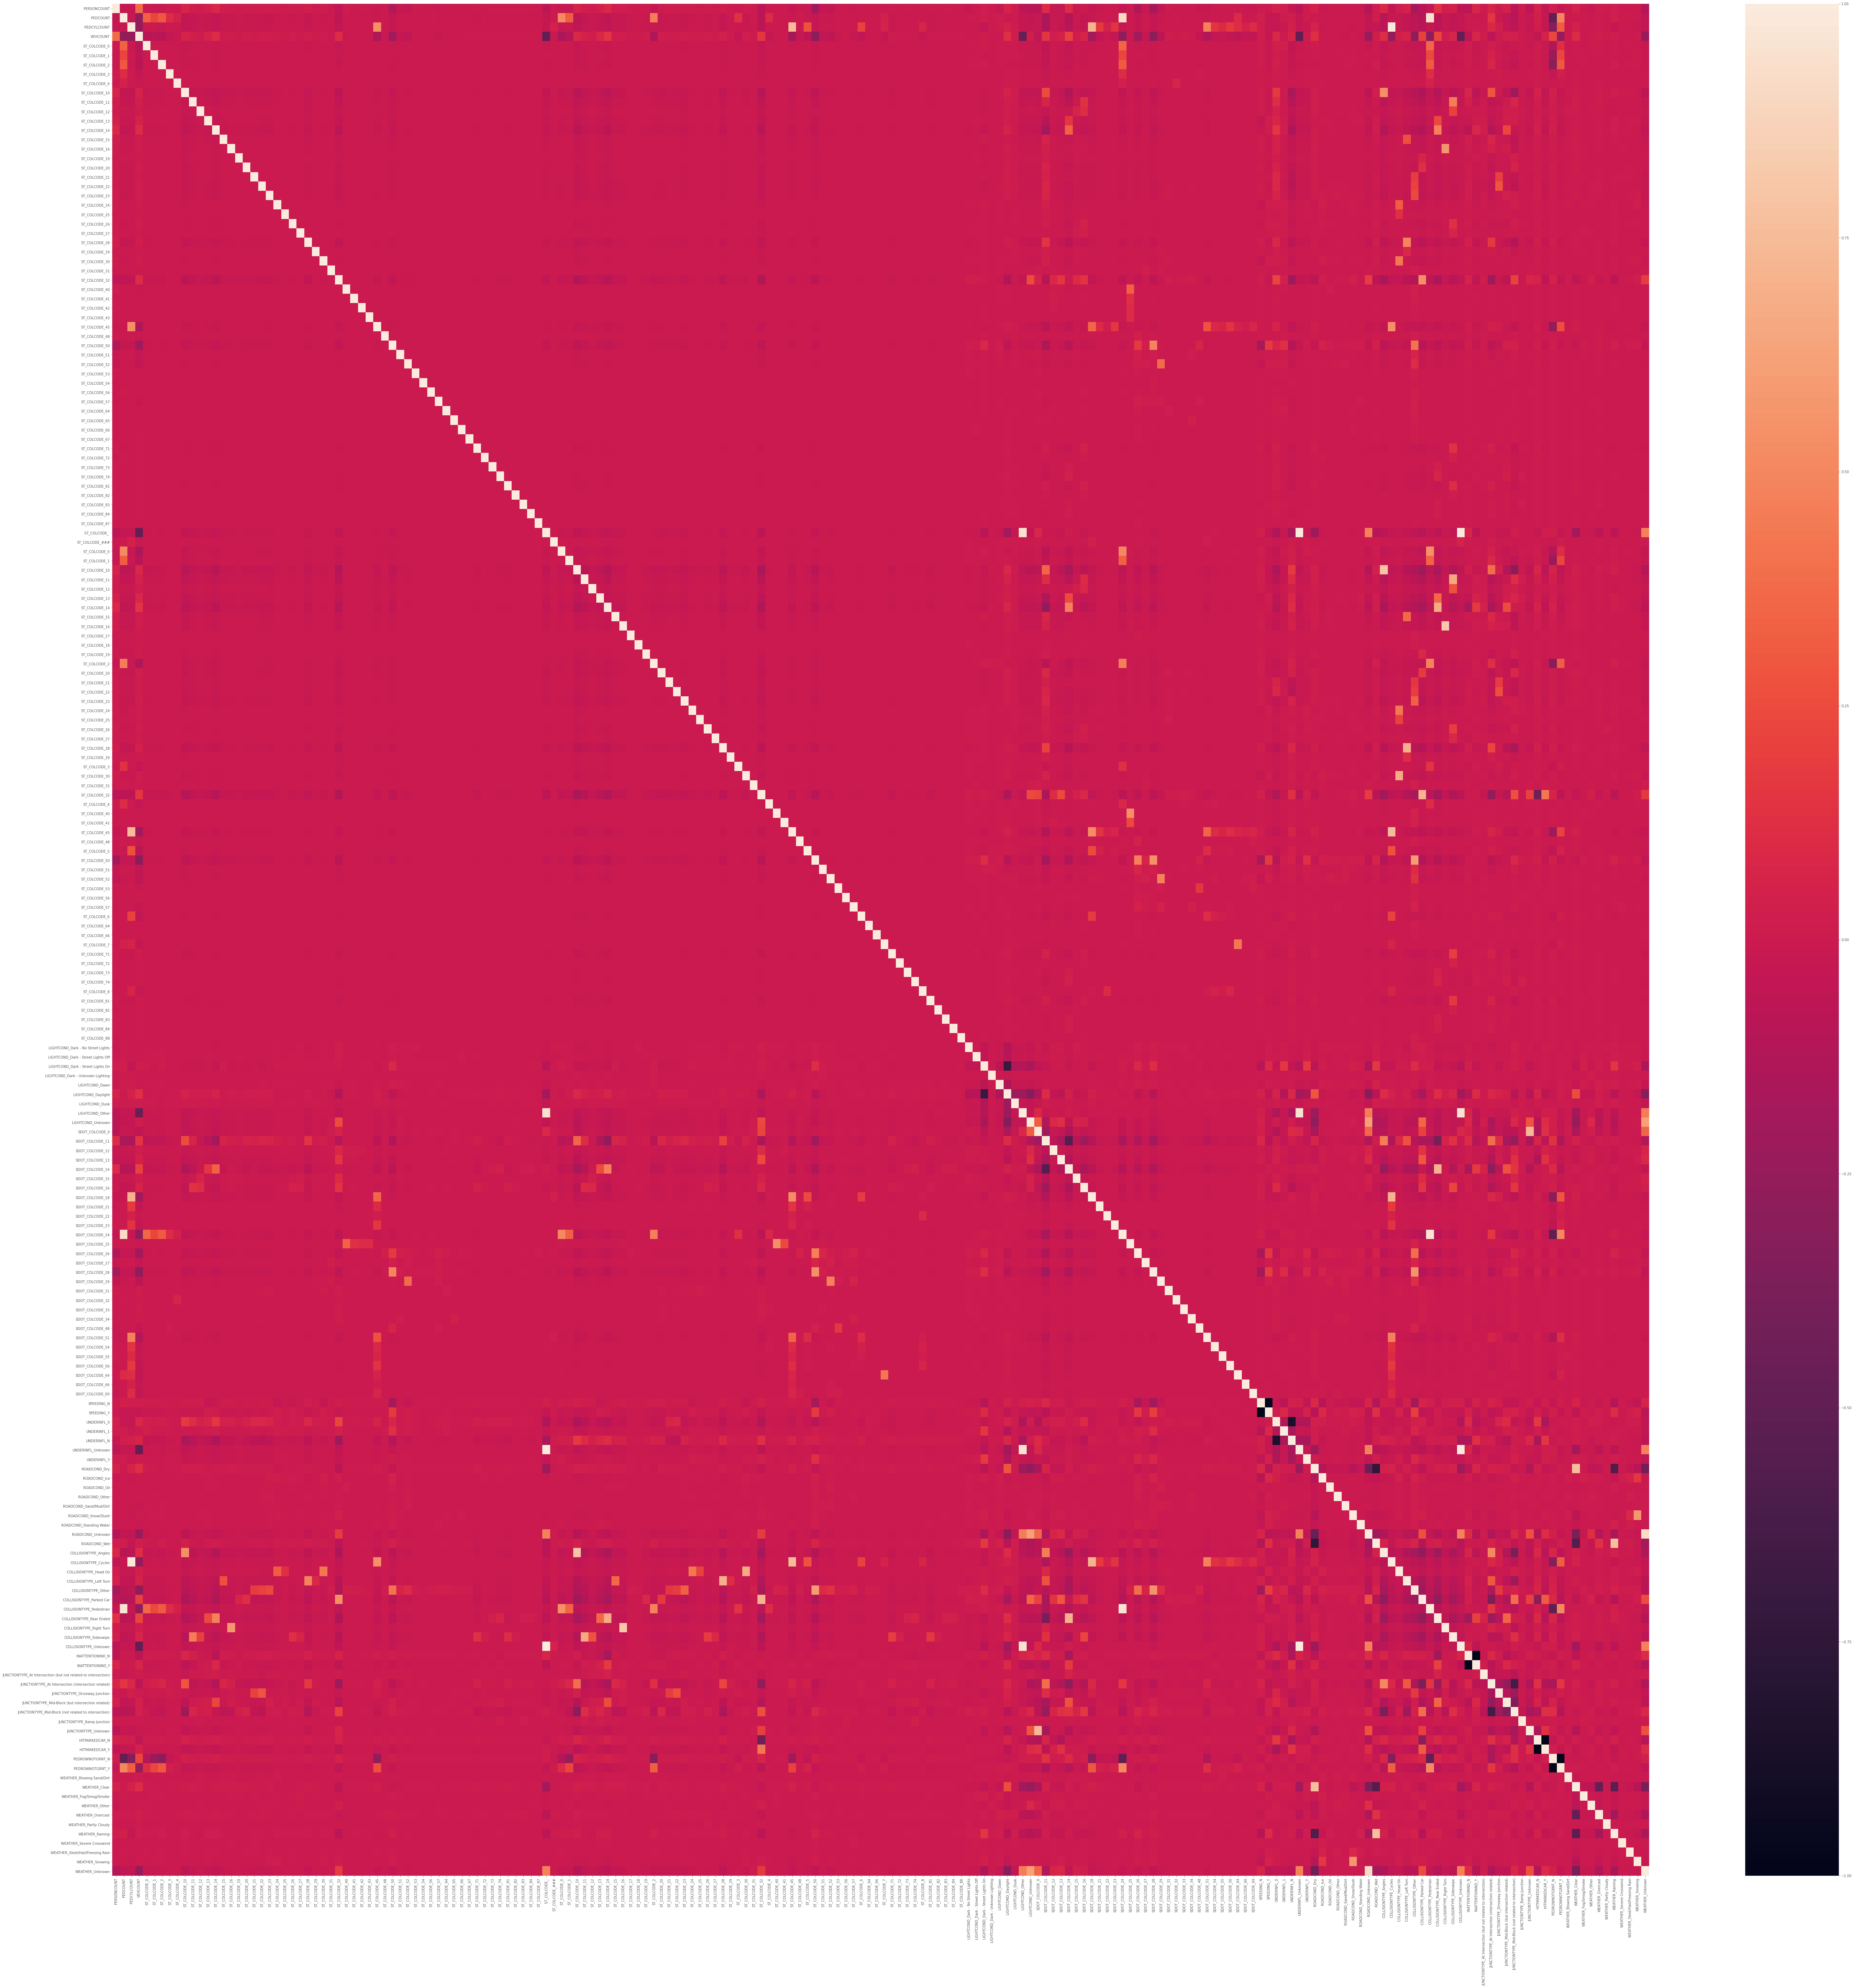

In [165]:
%%time
# Correlatio Graph
corr = df_crashData_ohe.corr()

# plot the heatmap
plt.figure(figsize=(100, 100))
sns.heatmap(corr,  
        xticklabels=corr.columns,
        yticklabels=corr.columns)

In [166]:
df_crashData_ohe.shape

(194580, 201)

In [400]:
df_crashData.columns

Index(['SEVERITYCODE', 'COLLISIONTYPE', 'PERSONCOUNT', 'PEDCOUNT',
       'PEDCYLCOUNT', 'VEHCOUNT', 'JUNCTIONTYPE', 'SDOT_COLCODE',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SPEEDING', 'ST_COLCODE', 'HITPARKEDCAR'],
      dtype='object')

In [391]:
tmpdata = df_crashData[df_crashData['VEHCOUNT'] == 3]
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,7538,57.957866
2,5468,42.042134


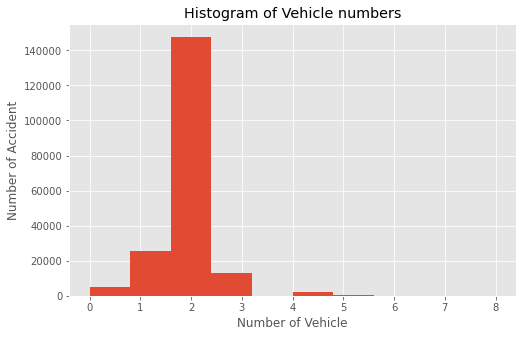

In [394]:
df_crashData['VEHCOUNT'].plot(kind='hist', figsize=(8, 5))


plt.title('Histogram of Vehicle numbers') # add a title to the histogram
plt.ylabel('Number of Accident') # add y-label
plt.xlabel('Number of Vehicle') # add x-label

plt.show()

In [397]:
tmpdata = df_crashData[df_crashData['PEDCOUNT'] == 1]
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
2,5998,89.844218
1,678,10.155782


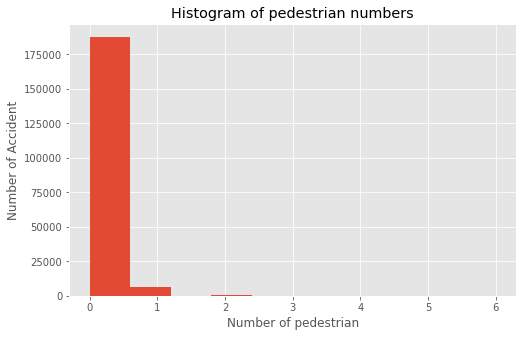

In [395]:
df_crashData['PEDCOUNT'].plot(kind='hist', figsize=(8, 5))


plt.title('Histogram of pedestrian numbers') # add a title to the histogram
plt.ylabel('Number of Accident') # add y-label
plt.xlabel('Number of pedestrian') # add x-label

plt.show()

In [405]:
tmpdata = df_crashData[df_crashData['WEATHER'] == 'Raining']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,21963,66.289388
2,11169,33.710612


In [407]:
tmpdata = df_crashData[df_crashData['SPEEDING'] == 'Y']
perc_data(tmpdata['SEVERITYCODE'])

,SEVERITYCODE,percent
1,5798,62.170277
2,3528,37.829723


## Preprocessing

### Balance data

In [167]:
# Set random_state
randseed = 4

# Set split ratio
split_rate = 0.3

In [168]:
# Imbalance Data
df_crashData_ohe['SEVERITYCODE'].value_counts()

1    136440
2     58140
Name: SEVERITYCODE, dtype: int64

### Upsample Severity class 2

In [171]:
# Separate majority and minority classes
df_upsamp1 = df_crashData_ohe[df_crashData_ohe.SEVERITYCODE == 1]
df_upsamp2 = df_crashData_ohe[df_crashData_ohe.SEVERITYCODE == 2]

# Upsample Severity class 2 as class 1
df_upsampled = resample(df_upsamp2, 
                        replace=True,     # sample with replacement
                        n_samples=136440, # to match class 1
                        random_state=randseed)   # reproducible results

# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_upsamp1, df_upsampled])

# Display new class counts
df_upsampled.SEVERITYCODE.value_counts()

2    136440
1    136440
Name: SEVERITYCODE, dtype: int64

In [172]:
# Save upsampled data to csv
df_upsampled.to_csv('Capstone_project\\dataset\\3_Data-Collisions_Cleaned_ohe_upsample_v3_0921.csv',index=False)

### Downsample Severity class 1

In [173]:
# Separate majority and minority classes
df_downsamp1 = df_crashData_ohe[df_crashData_ohe.SEVERITYCODE == 1]
df_downsamp2 = df_crashData_ohe[df_crashData_ohe.SEVERITYCODE == 2]

# Upsample Severity class 2 as class 1
df_downsampled = resample(df_downsamp1, 
                        replace=True,     # sample with replacement
                        n_samples=58140, # to match class 1
                        random_state=randseed)   # reproducible results

# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_downsamp2, df_downsampled])
 
# Display new class counts
df_downsampled.SEVERITYCODE.value_counts()

2    58140
1    58140
Name: SEVERITYCODE, dtype: int64

In [174]:
# Save upsampled data to csv
df_downsampled.to_csv('Capstone_project\\dataset\\4_Data-Collisions_Cleaned_ohe_downsample_v3_0921.csv',index=False)

### Split train and test data upsample

In [355]:
y = df_upsampled['SEVERITYCODE']
X = df_upsampled.drop('SEVERITYCODE',axis=1)
X_train_up, X_test_up, y_train_up, y_test_up = train_test_split(X, y, test_size=split_rate, random_state=randseed)
pd.Series(y_train_up).value_counts()

2    95721
1    95295
Name: SEVERITYCODE, dtype: int64

### Split train and test data downsample

In [176]:
y = df_downsampled['SEVERITYCODE']
X = df_downsampled.drop('SEVERITYCODE',axis=1)
X_train_down, X_test_down, y_train_down, y_test_down = train_test_split(X, y, test_size=split_rate, random_state=randseed)
pd.Series(y_train_down).value_counts()

2    40705
1    40691
Name: SEVERITYCODE, dtype: int64

### Nomalization, fit, transform with downsample data

In [177]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-3.74301149e-01, -2.37552740e-01, -2.12695272e-01,
         1.43899208e-01, -8.58124131e-02, -5.62687100e-02,
        -7.24399840e-02, -2.70467909e-02, -1.27837943e-02,
        -2.60154487e-01, -1.35682907e-01, -6.16306948e-02,
        -1.14356045e-01, -2.36189700e-01, -7.27392967e-02,
        -6.79231210e-02, -3.39664587e-02, -6.53183866e-02,
        -7.04949260e-02, -7.94286004e-02, -8.39624576e-02,
        -3.60593696e-02, -1.40654737e-02, -4.00268658e-02,
        -1.98935516e-02, -1.41958191e-01, -2.01087097e-02,
        -4.50008498e-02, -7.18347060e-03, -2.61151663e-01,
        -1.20921548e-02, -7.18347060e-03, -2.93257654e-03,
         0.00000000e+00, -1.12724154e-01, -5.86522874e-03,
        -1.49798214e-01, -2.25311678e-02, -4.84217501e-02,
        -7.75906841e-03,  0.00000000e+00, -6.55755328e-03,
        -1.09733101e-02, -1.34399099e-02, -7.18347060e-03,
        -4.14730735e-03, -4.14730735e-03, -3.93749615e-02,
        -1.13585039e-02, -1.57943097e-02, -3.03486437e-0

In [178]:
X_train_down_n, X_test_down_n, y_train_down_n, y_test_down_n = train_test_split(X, y, test_size=split_rate, random_state=randseed)
pd.Series(y_train_down_n).value_counts()

2    40705
1    40691
Name: SEVERITYCODE, dtype: int64

### Nomalization, fit, transform with upsample data

In [356]:
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:5]

array([[-3.70e-01, -2.37e-01, -2.12e-01,  1.42e-01, -8.56e-02, -5.76e-02,
        -7.20e-02, -2.74e-02, -1.33e-02, -2.59e-01, -1.35e-01, -6.08e-02,
        -1.14e-01, -2.36e-01, -7.03e-02, -6.59e-02, -3.40e-02, -6.54e-02,
        -6.98e-02, -7.93e-02, -8.44e-02, -3.81e-02, -1.31e-02, -4.21e-02,
        -1.88e-02, -1.43e-01, -2.07e-02, -4.60e-02, -7.16e-03, -2.63e-01,
        -1.28e-02, -8.12e-03, -4.28e-03, -1.91e-03, -1.14e-01, -6.90e-03,
        -1.50e-01, -2.41e-02, -5.04e-02, -7.16e-03, -1.91e-03, -6.05e-03,
        -1.33e-02, -1.27e-02, -5.41e-03, -3.83e-03, -5.74e-03, -3.94e-02,
        -1.03e-02, -1.83e-02, -3.12e-02, -3.33e-02, -7.16e-03, -1.01e-02,
        -1.30e-02, -1.91e-03, -1.54e-01, -1.05e-02, -1.27e-01, -8.09e-02,
        -3.88e-01,  5.05e+00, -8.03e-02, -1.76e-01, -3.30e-01, -9.93e-02,
        -9.70e-02, -5.41e-03, -4.28e-03, -4.30e-02, -1.13e-01, -9.24e-02,
        -6.14e-02, -7.18e-02, -1.18e-01, -5.17e-02, -2.34e-02, -5.84e-02,
        -2.72e-02, -2.06e-01, -2.95e-0

In [357]:
X_train_up_n, X_test_up_n, y_train_up_n, y_test_up_n = train_test_split(X, y, test_size=split_rate, random_state=randseed)
pd.Series(y_train_up_n).value_counts()

2    95721
1    95295
Name: SEVERITYCODE, dtype: int64

### Dimensionality Reduction / Feature Selection

In [824]:
# Option for Dimensionality Reduction
transformer = GenericUnivariateSelect(chi2, mode='k_best', param=30)
X_new = transformer.fit_transform(X, y)
X_new.shape

(116344, 30)

In [825]:
X_new

array([[2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [3, 0, 1, ..., 1, 0, 0],
       ...,
       [2, 0, 0, ..., 0, 0, 0],
       [2, 0, 0, ..., 0, 0, 0],
       [4, 0, 0, ..., 0, 0, 0]], dtype=int16)

### Normalization, fit, transform with full data

In [828]:
yfull = df_crashData_ohe['SEVERITYCODE']
Xfull = df_crashData_ohe.drop('SEVERITYCODE',axis=1)
Xfull = df_crashData_ohe
Xfull = preprocessing.StandardScaler().fit(Xfull).transform(Xfull.astype(float))
Xfull[0:5]

array([[-0.36369125, -0.23838907, -0.21273731, ...,  0.96081657,
        -0.15157594, -0.17029685],
       [-0.36369125, -0.23838907, -0.21273731, ..., -1.04078139,
        -0.15157594, -0.17029685],
       [ 0.33323688, -0.23838907,  4.61949811, ...,  0.96081657,
        -0.15157594, -0.17029685],
       [-0.36369125, -0.23838907, -0.21273731, ..., -1.04078139,
        -0.15157594, -0.17029685],
       [-0.36369125, -0.23838907, -0.21273731, ...,  0.96081657,
        -0.15157594, -0.17029685]])

In [829]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_rate, random_state=randseed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(81440, 212) (34904, 212) (81440,) (34904,)


## Modeling

### K-Nearest Neighbors

In [179]:
# Baseline parameter
# k = 5, weights = 'uniform' as default, Algorithm = 'kd_tree', leaf_size = 30 as default
k = 5

In [180]:
%%time
# feed normalized data
X_train_k = X_train_down_n
y_train_k = y_train_down_n
X_test_k  = X_test_down_n
y_test_k = y_test_down_n

#Train Model and Predict  
neigh = KNeighborsClassifier(n_neighbors = k,algorithm ='kd_tree').fit(X_train_k,y_train_k)
print(neigh)

yhatK = neigh.predict(X_test_k)
print(yhatK)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_k, yhatK))


KNeighborsClassifier(algorithm='kd_tree')
[2 1 1 ... 2 1 1]
Test set Accuracy:  0.6824905400756794
Wall time: 19min 33s


In [182]:
yhatK = neigh.predict(X_test_k)
yhatK[0:5]

array([2, 1, 1, 2, 2], dtype=int64)

In [184]:
print("Test set Accuracy: ", metrics.accuracy_score(y_test_k, yhatK))

Test set Accuracy:  0.6824905400756794


              precision    recall  f1-score   support

           1       0.68      0.70      0.69     17449
           2       0.69      0.67      0.68     17435

    accuracy                           0.68     34884
   macro avg       0.68      0.68      0.68     34884
weighted avg       0.68      0.68      0.68     34884

Confusion matrix, without normalization
[[12185  5264]
 [ 5812 11623]]


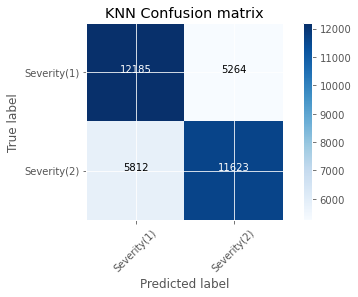

In [187]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_k, yhatK, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_k, yhatK))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='KNN Confusion matrix')

In [188]:
jaccard_score(y_test_k,yhatK, average='macro')

0.5179435865135966

In [189]:
f1_score(y_test_k,yhatK, average='macro')

0.6824081092822214

### Decision Trees

In [320]:
%%time
# Baseline parameter
# criterion = 'gini', splitter = 'best' as default, max_depth = 30

# feed unnormalized data
X_train_dt = X_train_down
y_train_dt = y_train_down
X_test_dt  = X_test_down
y_test_dt = y_test_down

#sevTree = DecisionTreeClassifier(criterion="entropy", max_depth=12)
sevTree = DecisionTreeClassifier(criterion="gini",max_depth=30)
print(sevTree) # it shows the default parameters

sevTree.fit(X_train_dt,y_train_dt)

yhatDT = sevTree.predict(X_test_dt)

print (yhatDT [0:5])
print (y_test_dt [0:5])

print("Test set Accuracy: ", metrics.accuracy_score(y_test_dt, yhatDT))


DecisionTreeClassifier(max_depth=30)
[2 1 1 2 1]
141557    2
24660     1
133815    1
3639      1
139467    1
Name: SEVERITYCODE, dtype: category
Categories (2, int64): [1, 2]
Test set Accuracy:  0.7057390207545007
Wall time: 3.78 s


              precision    recall  f1-score   support

           1       0.73      0.66      0.69     17449
           2       0.69      0.76      0.72     17435

    accuracy                           0.71     34884
   macro avg       0.71      0.71      0.71     34884
weighted avg       0.71      0.71      0.71     34884

Confusion matrix, without normalization
[[11451  5998]
 [ 4267 13168]]


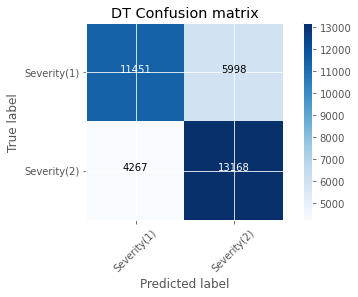

In [321]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_dt, yhatDT, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_dt, yhatDT))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='DT Confusion matrix')

In [322]:
jaccard_score(y_test_dt,yhatDT, average='macro')

0.5446248071721623

In [323]:
f1_score(y_test_dt,yhatDT, average='macro')

0.7050244024696706

### Decision Trees with Selected parameters

In [326]:
%%time
sevTree = DecisionTreeClassifier(criterion="gini", max_depth=20,max_features='auto',splitter='best')
print(sevTree)

sevTree.fit(X_train_dt,y_train_dt)

yhatDT = sevTree.predict(X_test_dt)

print (yhatDT [0:5])
print (y_test_dt [0:5])

print("Test set Accuracy: ", metrics.accuracy_score(y_test_dt, yhatDT))

DecisionTreeClassifier(max_depth=20, max_features='auto')
[1 1 1 2 2]
141557    2
24660     1
133815    1
3639      1
139467    1
Name: SEVERITYCODE, dtype: category
Categories (2, int64): [1, 2]
Test set Accuracy:  0.7073730076826052
Wall time: 598 ms


              precision    recall  f1-score   support

           1       0.76      0.60      0.67     17449
           2       0.67      0.81      0.74     17435

    accuracy                           0.71     34884
   macro avg       0.72      0.71      0.70     34884
weighted avg       0.72      0.71      0.70     34884

Confusion matrix, without normalization
[[10509  6940]
 [ 3268 14167]]


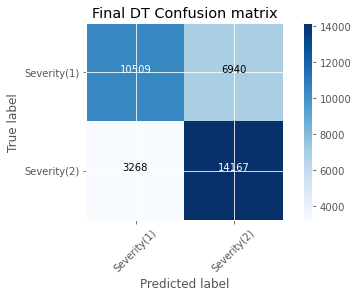

In [327]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_dt, yhatDT, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_dt, yhatDT))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='Final DT Confusion matrix')

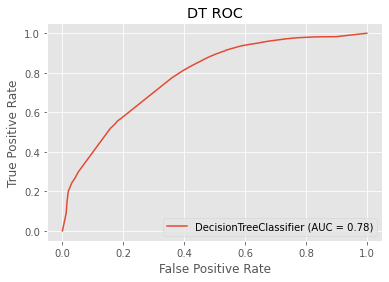

In [353]:

dt_disp = plot_roc_curve(sevTree, X_test_dt, y_test_dt)
plt.title('DT ROC')
plt.show()

### Decision Trees with Selected parameters and upsample data

In [361]:
%%time

# feed unnormalized data
X_train_dt = X_train_up
y_train_dt = y_train_up
X_test_dt  = X_test_up
y_test_dt = y_test_up

sevTree = DecisionTreeClassifier(criterion="gini", max_depth=20,max_features='auto',splitter='best')
print(sevTree)

sevTree.fit(X_train_dt,y_train_dt)

yhatDT = sevTree.predict(X_test_dt)

print (yhatDT [0:5])
print (y_test_dt [0:5])

print("Test set Accuracy: ", metrics.accuracy_score(y_test_dt, yhatDT))

DecisionTreeClassifier(max_depth=20, max_features='auto')
[1 1 1 1 2]
54233     1
6442      1
57852     1
64731     1
109325    2
Name: SEVERITYCODE, dtype: category
Categories (2, int64): [1, 2]
Test set Accuracy:  0.7219168376820092
Wall time: 1.53 s


              precision    recall  f1-score   support

           1       0.76      0.65      0.70     41145
           2       0.69      0.79      0.74     40719

    accuracy                           0.72     81864
   macro avg       0.73      0.72      0.72     81864
weighted avg       0.73      0.72      0.72     81864

Confusion matrix, without normalization
[[26864 14281]
 [ 8484 32235]]


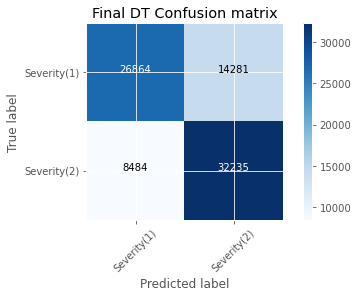

In [362]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_dt, yhatDT, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_dt, yhatDT))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='Final DT Confusion matrix')

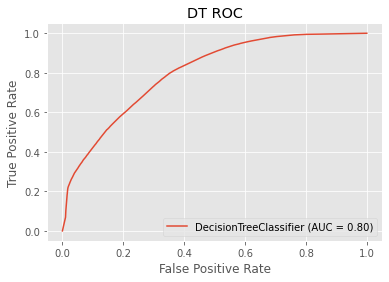

In [363]:

dt_disp = plot_roc_curve(sevTree, X_test_dt, y_test_dt)
plt.title('DT ROC')
plt.show()

### SVM (Support Vector Machines)

In [194]:
# Baseline parameter
# C = 1 as default, kernel = 'rbf' as default, degree = 3 as default, gamma = 'auto', coef = 0.0 as default

In [195]:
%%time
# feed normalized data
X_train_svm = X_train_down_n
y_train_svm = y_train_down_n
X_test_svm  = X_test_down_n
y_test_svm = y_test_down_n

clf = svm.SVC(kernel='rbf',gamma='auto')
print(clf) # it shows the default parameters

clf.fit(X_train_svm, y_train_svm) 

yhatS = clf.predict(X_test_svm)

print(yhatS [0:5])

print("Test set Accuracy: ", metrics.accuracy_score(y_test_svm, yhatS))


SVC(gamma='auto')
[2 1 1 2 2]
Test set Accuracy:  0.7154856094484577
Wall time: 1h 53min 41s


              precision    recall  f1-score   support

           1       0.76      0.64      0.69     17449
           2       0.69      0.80      0.74     17435

    accuracy                           0.72     34884
   macro avg       0.72      0.72      0.71     34884
weighted avg       0.72      0.72      0.71     34884

Confusion matrix, without normalization
[[11093  6356]
 [ 3569 13866]]


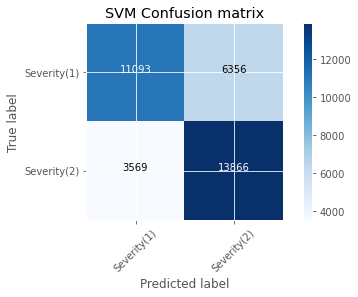

In [197]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_svm, yhatS, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_svm, yhatS))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='SVM Confusion matrix')

In [198]:
jaccard_score(y_test_svm, yhatS, average='macro')

0.5553055728398658

In [199]:
f1_score(y_test_svm,yhatS, average='macro')

0.7136763350918228

### Logistic Regression

In [340]:
# Baseline parameter
# penalty = l2, C = 0.01, solver = 'saga', max_iter=1000

In [345]:
%%time
# feed normalized data
X_train_lr = X_train_down_n
y_train_lr = y_train_down_n
X_test_lr  = X_test_down_n
y_test_lr = y_test_down_n

LR = LogisticRegression(C=0.01, solver='saga',max_iter=1000).fit(X_train_lr,y_train_lr)
print(LR)

yhatL = LR.predict(X_test_lr)
print(yhatL)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_lr, yhatL))


LogisticRegression(C=0.01, max_iter=1000, solver='saga')
[2 1 1 ... 2 1 2]
Test set Accuracy:  0.7158296066964798
Wall time: 5min 39s


              precision    recall  f1-score   support

           1       0.75      0.64      0.69     17449
           2       0.69      0.79      0.74     17435

    accuracy                           0.72     34884
   macro avg       0.72      0.72      0.71     34884
weighted avg       0.72      0.72      0.71     34884

Confusion matrix, without normalization
[[11212  6237]
 [ 3676 13759]]


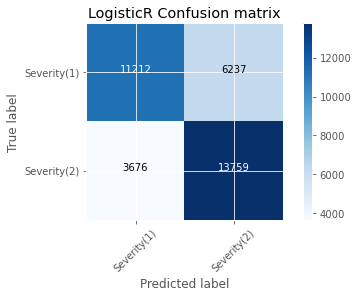

In [346]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_lr, yhatL, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_lr, yhatL))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='LogisticR Confusion matrix')

In [347]:
jaccard_score(y_test_lr, yhatL, average='macro')

0.5559903883648523

### Logistic Regression with Selected parameters

In [348]:
%%time

LR = LogisticRegression(C=1, solver='lbfgs',penalty='l2',max_iter=1000).fit(X_train_lr,y_train_lr)
print(LR)

yhatL = LR.predict(X_test_lr)
print(yhatL)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_lr, yhatL))

LogisticRegression(C=1, max_iter=1000)
[2 1 1 ... 2 2 2]
Test set Accuracy:  0.7162022703818369
Wall time: 4.48 s


              precision    recall  f1-score   support

           1       0.75      0.64      0.69     17449
           2       0.69      0.79      0.74     17435

    accuracy                           0.72     34884
   macro avg       0.72      0.72      0.71     34884
weighted avg       0.72      0.72      0.71     34884

Confusion matrix, without normalization
[[11214  6235]
 [ 3665 13770]]


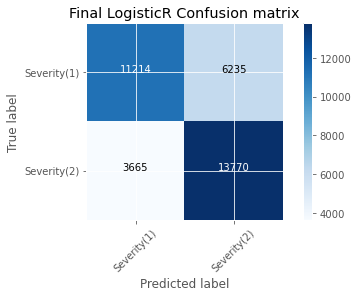

In [349]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_lr, yhatL, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_lr, yhatL))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='Final LogisticR Confusion matrix')

In [ ]:
from sklearn.metrics import plot_roc_curve

LogisticRegression(C=1, max_iter=1000)


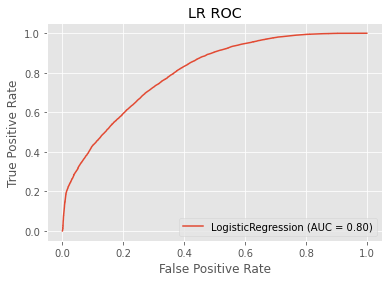

In [352]:

LR = LogisticRegression(C=1, solver='lbfgs',penalty='l2',max_iter=1000).fit(X_train_lr,y_train_lr)
print(LR)

#ax = plt.gca()
#lr_disp = plot_roc_curve(LR, X_test_lr, y_test_lr, ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(LR, X_test_lr, y_test_lr)
#lr_disp.plot(ax=ax, alpha=0.8)
plt.title('LR ROC')
plt.show()

### Logistic Regression with Selected parameters and upsample data

In [358]:
%%time
# feed normalized data
X_train_lr = X_train_up_n
y_train_lr = y_train_up_n
X_test_lr  = X_test_up_n
y_test_lr = y_test_up_n

LR = LogisticRegression(C=1, solver='lbfgs',penalty='l2',max_iter=1000).fit(X_train_lr,y_train_lr)
print(LR)

yhatL = LR.predict(X_test_lr)
print(yhatL)

print("Test set Accuracy: ", metrics.accuracy_score(y_test_lr, yhatL))

LogisticRegression(C=1, max_iter=1000)
[1 1 1 ... 2 2 1]
Test set Accuracy:  0.7179590540408483
Wall time: 17.7 s


              precision    recall  f1-score   support

           1       0.76      0.64      0.70     41145
           2       0.69      0.79      0.74     40719

    accuracy                           0.72     81864
   macro avg       0.72      0.72      0.72     81864
weighted avg       0.72      0.72      0.72     81864

Confusion matrix, without normalization
[[26424 14721]
 [ 8368 32351]]


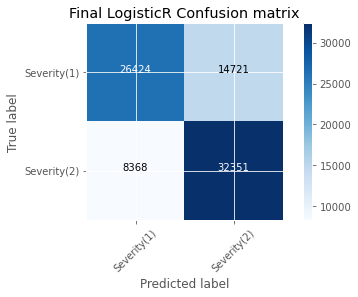

In [359]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test_lr, yhatL, labels=[1,2])
np.set_printoptions(precision=2)

print (classification_report(y_test_lr, yhatL))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Severity(1)','Severity(2)'],normalize= False,  title='Final LogisticR Confusion matrix')

In [ ]:
from sklearn.metrics import plot_roc_curve

LogisticRegression(C=1, max_iter=1000)


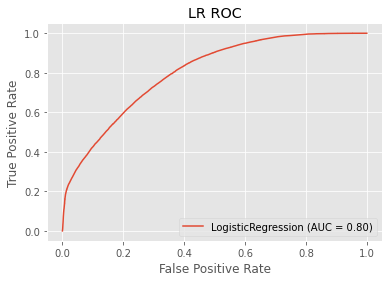

In [360]:

LR = LogisticRegression(C=1, solver='lbfgs',penalty='l2',max_iter=1000).fit(X_train_lr,y_train_lr)
print(LR)

#ax = plt.gca()
#lr_disp = plot_roc_curve(LR, X_test_lr, y_test_lr, ax=ax, alpha=0.8)
lr_disp = plot_roc_curve(LR, X_test_lr, y_test_lr)
#lr_disp.plot(ax=ax, alpha=0.8)
plt.title('LR ROC')
plt.show()